In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#Read CSV
df = pd.read_csv("Spotify Dataset Cleaned Model.csv")
df.drop(["Unnamed: 0","track_name","artist_name","popularity"],axis=1,inplace=True)

## Change categorical column to object type
df[["key","mode","time_signature"]] = df[["key","mode","time_signature"]].astype("object")

## One hot encoding for the categorical column
df = pd.get_dummies(df,["key","mode","time_signature"])

### Standard Scalling the dataset

Scale the data to same standard is compulsary in clustering method. (For the categorical columns and duration to be in same standars)

In [2]:
from sklearn.preprocessing import StandardScaler

# Copy the dataset
df_ss = df.copy()

# Standard Scaling the data
scaler = StandardScaler()
df_ss_scaled = scaler.fit_transform(df_ss)
df_ss_scaled = pd.DataFrame(df_ss_scaled,columns=df_ss.columns)

## PCA
Checking the best number of PCA to be used for the model

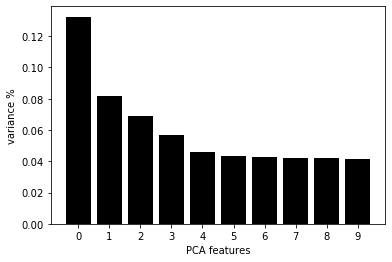

In [3]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

pca = PCA(n_components=10)
principalComponents = pca.fit_transform(df_ss_scaled)

features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)

plt.show()

The number of variance drop-off point usually is the indicator for the optimal number of PCA feature, from the graph above, the variance stabilize after 4 features, so we will use 4 features for the PCA.

### Applying PCA with n_components=4


In [4]:
### Setting the n_components to 4 feature
pca = PCA(n_components=4,random_state=101) 

###Fit and transforming the data
pca.fit(df_ss_scaled)
df_pca = pca.transform(df_ss_scaled)

### Checkin the shape of the PCA Data
df_pca.shape

(19333, 4)

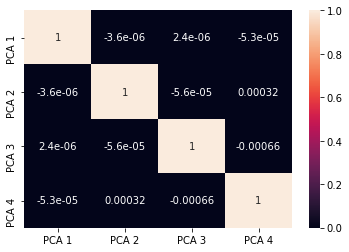

In [5]:
## Creating the dataframe from the PCA
df_pca = pd.DataFrame(df_pca,columns=["PCA 1","PCA 2","PCA 3","PCA 4"])
sns.heatmap(df_pca.corr(),annot=True)

The correlation is already almost 0 for all variables. It means the PCA already on the right track

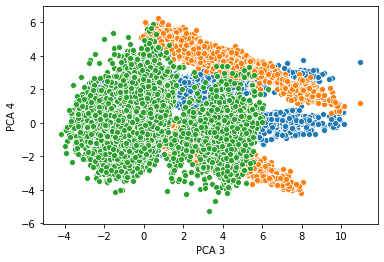

In [16]:
sns.scatterplot(x=df_pca["PCA 1"],y=df_pca["PCA 2"])
sns.scatterplot(x=df_pca["PCA 1"],y=df_pca["PCA 3"])
sns.scatterplot(x=df_pca["PCA 3"],y=df_pca["PCA 4"])

Sample from 3 combination of PCA, the data already quite clustered from using those PCA.

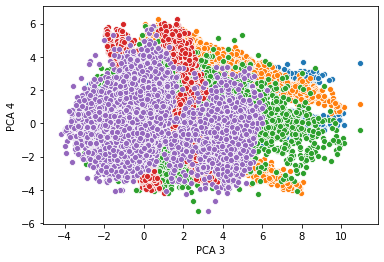

In [17]:
sns.scatterplot(x=df_pca["PCA 1"],y=df_pca["PCA 2"])
sns.scatterplot(x=df_pca["PCA 1"],y=df_pca["PCA 3"])
sns.scatterplot(x=df_pca["PCA 1"],y=df_pca["PCA 4"])
sns.scatterplot(x=df_pca["PCA 2"],y=df_pca["PCA 3"])
sns.scatterplot(x=df_pca["PCA 3"],y=df_pca["PCA 4"])

Overall, all the data formed one big cluster. It means that the variety of songs are huge. Every combination of audio features are possible to be make to be a song

## Using the Evaluation Methods to find the best number of cluster for KMeans

### Evaluation with Elbow Method

Text(0, 0.5, 'Inertia')

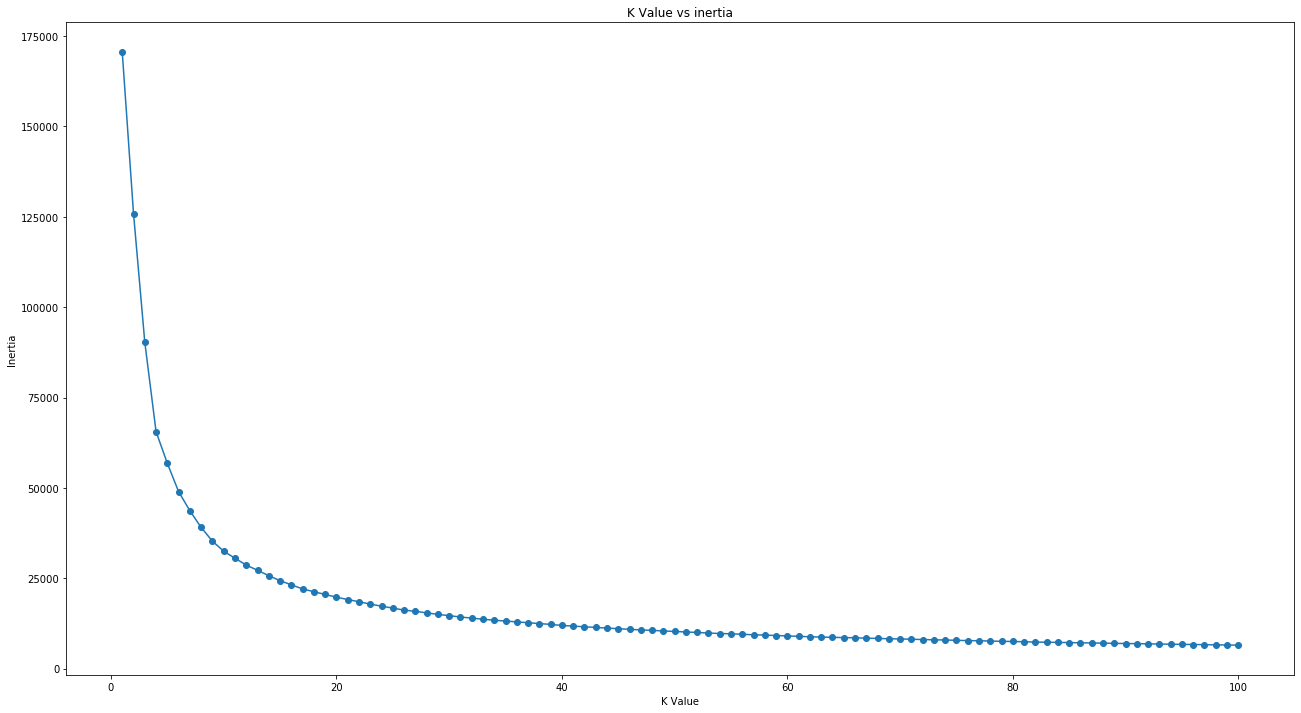

In [44]:
from sklearn.cluster import KMeans

inertia_list = []

for i in range (1,101):
    kmeans = KMeans(n_clusters=i,random_state=101)
    kmeans.fit(df_pca)
    inertia_list.append(kmeans.inertia_)
    
plt.figure(figsize=(22,12))
plt.plot(range(1,101),inertia_list, marker='o')
plt.title("K Value vs inertia")
plt.xlabel("K Value")
plt.ylabel("Inertia")

From the graph, it seems that the optimal number of cluster is around 8-15, so we will check with the silhoutte score to find the optimal one.

Text(0.5, 1.0, 'Silhoutte Score by n_cluster')

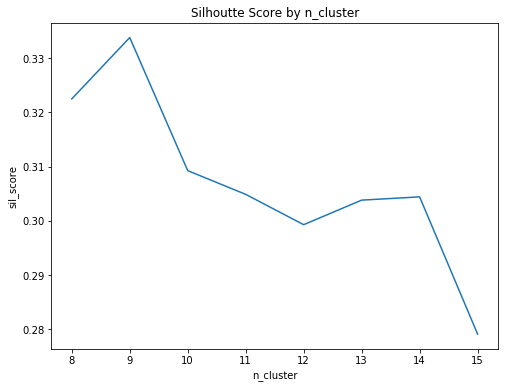

In [45]:
from sklearn.metrics import silhouette_score

sil = []
kmax = 15

for k in range(8, kmax+1):
    kmeans = KMeans(n_clusters = k).fit(df_pca)
    labels = kmeans.labels_
    sil.append(silhouette_score(df_pca, labels, metric = 'euclidean'))
    
dataSil = pd.DataFrame({
    "n_cluster" : np.arange(8,16,1),
    "sil_score" : sil
})

plt.figure(figsize=(8,6))
sns.lineplot(x=dataSil["n_cluster"],y=dataSil["sil_score"])
plt.title("Silhoutte Score by n_cluster")

From the silhoutte Score, clustering it to 9 cluster seems the most optimal. Since this clustering doesn't have any specific target cluster. I will just continue to use according the best score.

## Using K=9 for Labelling
For labelling, the clustered data will be labeled with music genre according to the means of the feature

Features that can be used to label the genre:
- danceability
- energy
- loundness
- mode
- acoustiness
- instrumentalness
- liveness
- valence
- tempo

In [6]:
# Fitting the model
kmeans = KMeans(n_clusters=9,random_state=101)
kmeans.fit(df_pca)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=9, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=101, tol=0.0001, verbose=0)

In [8]:
## read dataset for reference
dfRef = pd.read_csv("Spotify Dataset Cleaned Ref.csv")
dfRef.drop(["Unnamed: 0","index"],axis=1,inplace=True)

## Labelling both dataframes
dfRef["genre"] = kmeans.labels_
df["genre_label"] = kmeans.labels_

# Create Summary Dataframe with Mean for every feature per category


## Function to take outlier per feature
def take_outlier(item,feature):
    a = dfRef[dfRef["genre"] == item][feature]
    iqr = a.quantile(0.75) - a.quantile(0.25)
    lower_limit = a.quantile(0.25)-iqr
    upper_limit = a.quantile(0.75)+iqr
    return round(dfRef[(dfRef["genre"] == item) & (dfRef[feature] < upper_limit) & (dfRef[feature] > lower_limit)][feature].mean(),4)

danceability = []
energy = []
loudness = []
acousticness = []
instrumentalness = []
liveness = []
valence = []
tempo = []
speechiness = []
audio_features = ["danceability","energy","loudness","mode",'acousticness','instrumentalness',"liveness","valence","tempo","speechiness"]

for item in range(0,9):
    danceability.append(take_outlier(item,"danceability"))
    energy.append(take_outlier(item,"energy"))
    loudness.append(take_outlier(item,"loudness"))
    acousticness.append(take_outlier(item,"acousticness"))
    instrumentalness.append(take_outlier(item,"instrumentalness"))
    liveness.append(take_outlier(item,"liveness"))
    valence.append(take_outlier(item,"valence"))
    tempo.append(take_outlier(item,"tempo"))
    speechiness.append(take_outlier(item,"speechiness"))
    
summary_genre = pd.DataFrame({
    "danceability" : danceability,
    "energy" : energy,
    "loudness" : loudness,
    'acousticness' : acousticness,
    'instrumentalness' : instrumentalness,
    'liveness' : liveness,
    'valence' : valence,
    'tempo' : tempo,
    'speechiness' : speechiness
},index=["cat0",'cat1','cat2','cat3','cat4','cat5','cat6','cat7','cat8'])
summary_genre

,danceability,energy,loudness,acousticness,instrumentalness,liveness,valence,tempo,speechiness
cat0,0.7038,0.7011,-5.6968,0.1268,0.0000,0.1291,0.6201,119.4799,0.0872
cat1,0.5702,0.3968,-9.6268,0.5918,0.0011,0.1120,0.3152,109.5219,0.0398
cat2,0.7299,0.6890,-5.7839,0.1317,0.0000,0.1282,0.6010,117.7829,0.1287
cat3,0.5296,0.5455,-6.8413,0.3893,0.0000,0.1326,0.4351,131.9123,0.0454
cat4,0.2937,0.0872,-23.3402,0.9578,0.9118,0.1040,0.1010,94.9623,0.0423
cat5,0.2813,0.1250,-21.5246,0.9377,0.8544,0.1045,0.1115,102.4899,0.0437
cat6,0.5215,0.7536,-5.4285,0.0553,0.0000,0.1955,0.3824,129.9244,0.0501
cat7,0.5404,0.7725,-5.2470,0.0457,0.0001,0.2112,0.3775,129.9971,0.0655
cat8,0.5910,0.4296,-9.5420,0.5084,0.0080,0.1136,0.2814,106.1739,0.0532


In [9]:
## Filter the song per category and manually check their genre
dfRef[dfRef["genre"]==8].sort_values(by="popularity",ascending=False).head(10)

,track_id,track_name,artist_name,id,uri,track_href,analysis_url,year,danceability,energy,...,acousticness,instrumentalness,liveness,valence,tempo,type,duration_ms,time_signature,popularity,genre
10,3ZCTVFBt2Brf31RLEnCkWJ,everything i wanted,Billie Eilish,3ZCTVFBt2Brf31RLEnCkWJ,spotify:track:3ZCTVFBt2Brf31RLEnCkWJ,https://api.spotify.com/v1/tracks/3ZCTVFBt2Brf...,https://api.spotify.com/v1/audio-analysis/3ZCT...,2019,0.704,0.225,...,0.9020,0.657000,0.1060,0.2430,120.006,audio_features,245426.0,4.0,93,8
1915,0u2P5u6lvoDfwTYjAADbn4,lovely (with Khalid),Billie Eilish,0u2P5u6lvoDfwTYjAADbn4,spotify:track:0u2P5u6lvoDfwTYjAADbn4,https://api.spotify.com/v1/tracks/0u2P5u6lvoDf...,https://api.spotify.com/v1/audio-analysis/0u2P...,2018,0.351,0.296,...,0.9340,0.000000,0.0950,0.1200,115.284,audio_features,200186.0,4.0,90,8
24,3eekarcy7kvN4yt5ZFzltW,HIGHEST IN THE ROOM,Travis Scott,3eekarcy7kvN4yt5ZFzltW,spotify:track:3eekarcy7kvN4yt5ZFzltW,https://api.spotify.com/v1/tracks/3eekarcy7kvN...,https://api.spotify.com/v1/audio-analysis/3eek...,2019,0.598,0.427,...,0.0546,0.000006,0.2100,0.0605,76.469,audio_features,175721.0,4.0,89,8
1913,285pBltuF7vW8TeWk8hdRR,Lucid Dreams,Juice WRLD,285pBltuF7vW8TeWk8hdRR,spotify:track:285pBltuF7vW8TeWk8hdRR,https://api.spotify.com/v1/tracks/285pBltuF7vW...,https://api.spotify.com/v1/audio-analysis/285p...,2018,0.511,0.566,...,0.3490,0.000000,0.3400,0.2180,83.903,audio_features,239836.0,4.0,89,8
57,5DqdesEfbRyOlSS3Tf6c29,It's You,Ali Gatie,5DqdesEfbRyOlSS3Tf6c29,spotify:track:5DqdesEfbRyOlSS3Tf6c29,https://api.spotify.com/v1/tracks/5DqdesEfbRyO...,https://api.spotify.com/v1/audio-analysis/5Dqd...,2019,0.732,0.463,...,0.3740,0.000000,0.1940,0.3970,95.971,audio_features,212607.0,4.0,88,8
62,6ocbgoVGwYJhOv1GgI9NsF,7 rings,Ariana Grande,6ocbgoVGwYJhOv1GgI9NsF,spotify:track:6ocbgoVGwYJhOv1GgI9NsF,https://api.spotify.com/v1/tracks/6ocbgoVGwYJh...,https://api.spotify.com/v1/audio-analysis/6ocb...,2019,0.778,0.317,...,0.5920,0.000000,0.0881,0.3270,140.048,audio_features,178627.0,4.0,88,8
13,1iSqfoUFnQwV0QW1EfUit8,Suicidal,YNW Melly,1iSqfoUFnQwV0QW1EfUit8,spotify:track:1iSqfoUFnQwV0QW1EfUit8,https://api.spotify.com/v1/tracks/1iSqfoUFnQwV...,https://api.spotify.com/v1/audio-analysis/1iSq...,2019,0.735,0.369,...,0.3340,0.000000,0.1260,0.2350,140.004,audio_features,222997.0,4.0,88,8
1935,4ZLzoOkj0MPWrTLvooIuaa,Get You The Moon (feat. Snøw),Kina,4ZLzoOkj0MPWrTLvooIuaa,spotify:track:4ZLzoOkj0MPWrTLvooIuaa,https://api.spotify.com/v1/tracks/4ZLzoOkj0MPW...,https://api.spotify.com/v1/audio-analysis/4ZLz...,2018,0.498,0.235,...,0.7200,0.000000,0.1440,0.0895,118.917,audio_features,179080.0,4.0,87,8
34,5a6pdCHlWS2ekOOQ70QnAr,July,Noah Cyrus,5a6pdCHlWS2ekOOQ70QnAr,spotify:track:5a6pdCHlWS2ekOOQ70QnAr,https://api.spotify.com/v1/tracks/5a6pdCHlWS2e...,https://api.spotify.com/v1/audio-analysis/5a6p...,2019,0.708,0.186,...,0.8680,0.000000,0.0779,0.3210,72.541,audio_features,156107.0,4.0,86,8
3868,7hDVYcQq6MxkdJGweuCtl9,ocean eyes,Billie Eilish,7hDVYcQq6MxkdJGweuCtl9,spotify:track:7hDVYcQq6MxkdJGweuCtl9,https://api.spotify.com/v1/tracks/7hDVYcQq6Mxk...,https://api.spotify.com/v1/audio-analysis/7hDV...,2017,0.511,0.363,...,0.8160,0.031700,0.0840,0.1690,144.892,audio_features,200379.0,4.0,85,8


Checking sample manualy from top 15 song per category by listening to the song, check on google and cross the data with the number from the table above

In [86]:
summary_genre.to_csv("Summary Genre.csv")

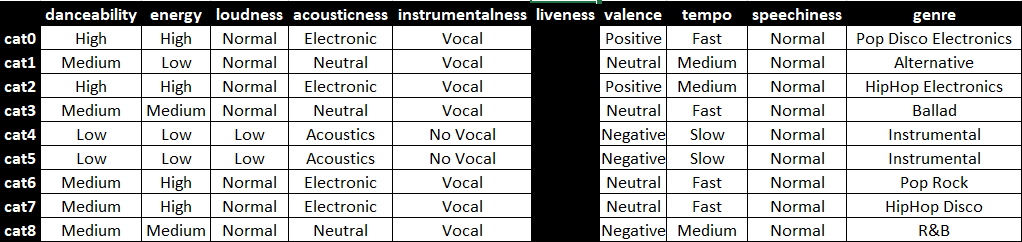

In [96]:
## Mapping the genre from number to new category
dfRef["genre"] = dfRef["genre"].map({
    0 : "Pop Disco Electronics",
    1 : "Alternative",
    2 : "HipHop Electronics",
    3 : "Ballad",
    4 : "Instrumental",
    5 : "Instrumental",
    6 : "Pop Rock",
    7 : "HipHop Disco",
    8 : "R&B"
})

dfRef.to_csv("Spotify Full Data with Genre.csv")

## Export the model to pickle

In [175]:
import pickle

## Scaler
pickle.dump(scaler, open('scaler.sav','wb'))


## PCA
pickle.dump(pca, open('pca.sav',"wb"))

# #KMEANS
pickle.dump(kmeans, open('kmeans.sav',"wb"))